<br>[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)<br>

# Accessing and visualizing NetCDF data

This notebook demonstrates how to read a PECDv4.2 NetCDF file containing ERA5 2-metre air temperature data on the European domain, how to explore its metadata, and how to create four simple visualizations:
1. A map showing the mean temperature at each grid point over the time period considered (year 2024).
2. A line plot with a time series of hourly temperature values at the nearest grid point to a user-specified location.
3. An empirical cumulative distribution (ECDF) plot, along with the extraction of some relevant quantiles, for the hourly temperature values at the selected grid point.
4. A line plot with a time series of daily and monthly mean temperature values at the same grid point of 2.

For illustration purposes, this notebook uses a short temporal subsample of the PECDv4.2 dataset. This approach is intended to demonstrate the workflow and methodology rather than to produce robust, policy-relevant impact assessments.
It is important to emphasize that for rigorous climate impact studies, the use of such limited data is not sufficient. Reliable analyses should be based on longer time series (typically at least 30 years).

In the following sections, you will:

- Open the 2024 temperature NetCDF file, which you can find in the Input section of this notebook.
- Compute a mean across the time dimension and plot it on a map.
- Select a location, extract data from the nearest grid point and visualize its hourly temperature evolution.
- Compute the temperature ECDF, visualize it and exctract some quantiles.
- For the same grid point, visualize its daily and monthly mean temperature time evolution in the same plot.

All these operations will be performed using the Python programming language.

> **Note**  
>[ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) is the fifth-generation atmospheric reanalysis program developed by the European Centre for Medium-Range Weather Forecasts (ECMWF) in collaboration with the Copernicus Climate Change Service (C3S). It operates on a global scale and has a spatial resolution of $0.25° \times \ 0.25°$ (latitude and longitude), which corresponds to approximately 31 km; estimates of atmospheric
variables are provided hourly throughout a temporal coverage of about eight decades, from 1940 to today.

> **Note**  
> [2-metre temperature](https://codes.ecmwf.int/grib/param-db/167) (short name t2m) is the temperature of air at 2m above the surface of land, sea or in-land waters. It is an istantaneous parameter (more information [here](https://confluence.ecmwf.int/display/CKB/Parameters+valid+at+the+specified+time)), it is expressed in Kelvin and it is provided at hourly resolution.

## Learning objectives 🎯

In this notebook you will learn how to work with climate data in NetCDF format using Python. You will explore the structure and metadata of a PECD gridded file from the historical stream (with similar considerations for the projection stream), compute temporal aggregates of 2-metre air temperature, and create meaningful visualizations to represent these results. Specifically, you will extract and plot the mean temperature values over a given period and generate time series (hourly, daily and monthly temperature evolution) for a specific location of your choice.

By the end of this notebook, you will have a practical understanding of how to handle gridded climate data with Python tools such as xarray, pandas and matplotlib, and you will be able to adapt these techniques to similar datasets and applications.

The code structure is kept as simple as possible, so you can easily reuse and adapt for visualizing other files, variables, or periods.

## Target Audience 🎯

**Anyone** interested in downloading, exploring, and visualizing gridded NetCDF files from the PECDv4.2

## Prepare your environment

### Import required packages

We begin by importing the required packages: these include [numpy](https://numpy.org/doc/stable/) and [xarray](https://docs.xarray.dev/en/stable/), which are used for handling multidimensional arrays of data. [Pandas](https://pandas.pydata.org/) is a widely used library for data manipulation and analysis, here useful to work with time coordinates format. The [os](https://docs.python.org/3/library/os.html) module provides a way to interact with the operating system and it is used here to manipulate paths; [matplotlib](https://matplotlib.org/) is a library for creating static, animated and interactive visualizations in Python. [cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a Python package designed for geospatial data processing that allows to produce maps and other geospatial data analyses.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cdsapi
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

### Set up the CDS API and your credentials

This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes, like ```"your_api_key"```). Your token can be found on the CDS portal at: https://cds.climate.copernicus.eu/profile

In [2]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example, we use data from the PECD version "PECD4.2" for the "Historical" temporal stream (based on "ERA5 reanalysis" data). The selected variable is the "2m temperature", taken for the year 2024 and with spatial resolution of 0.25°.

The API request reflecting these selections is shown in the next cell.

In [3]:
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "year": ["2024"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["0_25_degree"],
}

Next, we will create a dedicated folder to store our data, call the retrieve method and unzip the downloaded data to be ready to use our NetCDF file.

In [ ]:
# create folder
input_dir = "cds_data/explore_netcdf_data/"
os.system(f"mkdir -p {input_dir}")

# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/data.zip")

# Unzipping the file in our folder
zip_path = os.path.join(input_dir, "data.zip")
os.system(f"unzip {zip_path} -d {input_dir}")

## Open the NetCDF (.nc) file, check temporal-spatial domain and temperature units

### Open and inspect file

It is always good practice to have a quick general look at the data and metadata before proceeding with any operation. For starters, we can open our NetCDF file as a [Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) object and inspect some general information contained in it.

In [3]:
# retrive the complete file path
filename = (
    "H_ERA5_ECMW_T639_TA-_0002m_Pecd_025d_S202401010000_E202412312300"
    "_INS_MAP_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.nc"
)
file_path = os.path.join(input_dir, filename)

# open file, chunk along time dimension to improve performance
ds = xr.open_dataset(file_path, chunks={"time": 744})
# visualize metadata
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 8784, latitude: 229, longitude: 305)
Coordinates:
  * latitude   (latitude) float32 916B 75.0 74.75 74.5 74.25 ... 18.5 18.25 18.0
  * time       (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
  * longitude  (longitude) float32 1kB -31.0 -30.75 -30.5 ... 44.5 44.75 45.0
Data variables:
    t2m        (time, latitude, longitude) float32 2GB dask.array<chunksize=(744, 229, 305), meta=np.ndarray>
Attributes:
    title:        2 metre temperature; data for ENTSO-E PECD Version 4.2; fil...
    institution:  Copernicus Climate Change Service, Sectoral Information Sys...
    history:      2025-02-19 08:50:22 GMT by write_hist_xr_to_nc-0.1.dev51+g1...
    references:   
    Conventions:  CF-1.12-draft
    source:       ERA5 reanalysis data provided by ECMWF (https://www.ecmwf.i...

We see that the Dataset contains one variable called ```t2m```, which indeed represents the 2-metre air temperature. We will select this to compute operations on the actual temperature values. The spatial and temporal location of the grid points are given by ```latitude```, ```longitude```, and ```time``` coordinates. We will call these in case we must filter or produce subselections of the data. Let's now check what the temporal and spatial domains of our file are.

### Temporal domain

The following code cell will print the temporal grid of our input file.

In [39]:
# get the first time coordinate
first_t = pd.to_datetime(ds.time.isel(time=0).item())
# get the second time coordinate
second_t = pd.to_datetime(ds.time.isel(time=1).item())
# get the last time coordinate
last_t = pd.to_datetime(ds.time.isel(time=-1).item())

print(f"Temporal grid: {{{first_t}, {second_t}, ..., {last_t}}}")

Temporal grid: {2024-01-01 00:00:00, 2024-01-01 01:00:00, ..., 2024-12-31 23:00:00}


As expected, we see that our time coordinates cover the entire 2024 year. By looking at the second time coordinate, we can understand that the ```t2m``` values are stored with hourly resolution. We might here evaluate whether this resolution suits our needs, or if we should temporally aggregate the data.

### Spatial domain

Following a similar procedure to the one employed earlier, we can obtain the spatial domain of our NetCDF file.

In [40]:
# get spatial boundaries
lat_min = ds.latitude.min().item()
lat_max = ds.latitude.max().item()
lon_min = ds.longitude.min().item()
lon_max = ds.longitude.max().item()
print(f"Spatial domain: latitude {lat_min} to {lat_max}, longitude {lon_min} to {lon_max}")

Spatial domain: latitude 18.0 to 75.0, longitude -31.0 to 45.0


We can already see from the metadata printed above that latitude and longitude are expressed in decimal degrees, with a resolution of 0.25°. Here we understand that our spatial domain does not cover the entire globe, but it is focused on one specific area (the European PECD area).

### Check temperature units

To understand the units in which our temperature is expressed, we inspect the attributes associated with that specific variable.

In [4]:
t2m = ds.t2m
print(t2m.attrs)
units = t2m.attrs["units"]
print(f"2 metre temperature expressed in {units} units")

{'units': 'K', 'long_name': '2 metre temperature', 'short_name': 't2m', 'standard_name': '2_metre_temperature'}
2 metre temperature expressed in K units


We notice that temperature is expressed in Kelvin. We should keep the units in mind when processing any variable, especially temperature, which is commonly seen both in Celsius and Kelvin. Some energy conversion (or other kinds of) models might request the climate input data to be fed at specific units: in such cases, a conversion might be necessary. In this example case, we will choose to convert the data from Kelvin to degrees Celsius to make the results easier to interpret.

> **Note**  
> Remember that the following conversion from Kelvin to Celsius degrees holds:
>
>$0\ \mathrm{K} = (0 - 273.15)\ °\mathrm{C} = -273.15\ °\mathrm{C}$


## Annual mean temperature map


### Compute and visualize the annual mean temperature for each grid point

The following section will focus on calculating and plotting the temporal mean of ```t2m``` at each grid point across our spatial domain. These maps highlight spatial temperature gradients (e.g. coastal-inland, elevation) and help spot possible artifacts. The result is directly useful for downstream energy analyses, as t2m drives, for instance, Solar Photovoltaic (SPV) and Hydropower conversion models.

Repeating the same map year by year, loading the corresponding NetCDF files, provides an overview of how ```t2m``` evolves over time, offering an initial visual diagnostic of potential climate change signals (e.g., warming trends or shifting gradients).

We start by converting temperature values from Kelvin to Celsius degrees.

In [5]:
# convert to Celsius degrees
t2m_c = t2m - 273.15

We now compute the mean value at each grid point across all the temporal domain.

In [6]:
# annual mean temperature (units: °C)
t2m_mean_y = t2m_c.mean(dim="time")

Next, we load the mean values in memory. Because the dataset was opened with ```chunks={"time": 744}```, all calculations are "lazy" (i.e., they are not performed until explicitly requested) by default; the call ```.compute()``` forces this particular operation to execute immediately.

In [7]:
# compute and load everything in memory
data_plt = t2m_mean_y.compute()

Finally, we construct and display the mean temperature map. To simplify the notation, we define a few helper variables used below.

In [8]:
# fixed variables
num_levels = 11  # number of (discrete) colorbar levels
figname = "map.png"  # name of the final figure
save_path = "results/explore_netcdf_data"  # path to save figures
os.system(f"mkdir -p {save_path}")
cbar_label = "t2m (°C)"  # colorbar label
title = "ERA5 mean 2 metre temperature 2024"  # title of the plot

We now build the plot, opting for a discrete colorbar to improve the readability of temperature levels.

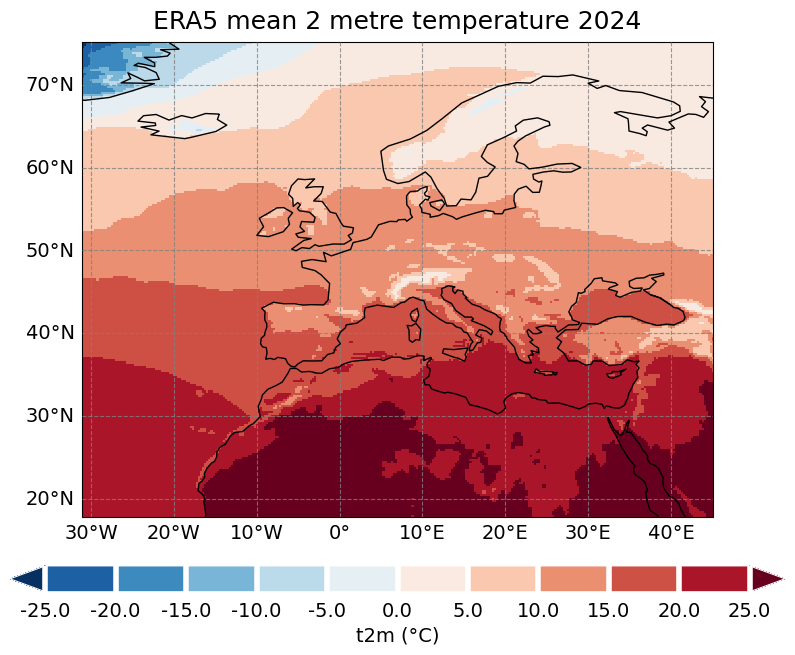

In [ ]:
# plot the data

# minimum and maximum values of t2m in colorbar
vmin = -25
vmax = 25

# projection
projection = ccrs.PlateCarree()
transform = ccrs.PlateCarree()

# create a discrete colormap
cmap = "RdBu_r"

# levels
levels = np.linspace(vmin, vmax, num_levels)
# adjusting colors based on levels and actual ds min and max
rdbu_cmap = plt.get_cmap(cmap)
selected_colors = rdbu_cmap(np.linspace(0, 1, ((num_levels - 1) + 2)))

custom_cmap = LinearSegmentedColormap.from_list("RdBu_r", selected_colors)

# Plotting
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)
# main map
imax = data_plt.plot.imshow(
    ax=ax,
    levels=levels,
    transform=transform,
    cmap=custom_cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    zorder=0,
)

# defining ticks
ticks = np.arange(vmin, vmax, ((vmax - vmin) / (num_levels - 1)))
last = [vmax]
ticks = np.concatenate((ticks, last), axis=0)

# defining colorbar parameters
rc2 = {"axes.edgecolor": "white", "xtick.color": "white", "xtick.labelcolor": "black"}

with plt.rc_context(rc2):

    cbar = plt.colorbar(
        imax,
        orientation="horizontal",
        aspect=30,
        ticks=ticks,
        pad=0.08,
        shrink=1,
        spacing="uniform",
        drawedges=True,
    )

    cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(cbar_label, fontsize=14)
    cbar.dividers.set_linewidth(4)

# add coastlines
ax.coastlines(zorder=20)
# add lat-lon grid
gr = ax.gridlines(draw_labels=True, zorder=10, alpha=0.8, color="gray", linestyle="--")
gr.xlabel_style = {"size": 14}
gr.ylabel_style = {"size": 14}
gr.top_labels = False
gr.right_labels = False

# add title
ax.set_title(title, fontsize=18, pad=10)  # pad: spacing of title from figure

# save and show the plot
plt.savefig(os.path.join(save_path, figname), dpi=200, bbox_inches="tight")
plt.show()
plt.close()

## Temperature time series and empirical CDF

We now proceed on extracting other important information from our input NetCDF file. In particular, we are going to calculate hourly and daily temperature time series for a specific location inside our spatial domain. Also, we will calculate the empirical cumulative distribution function of ```t2m``` at the same grid point. As before, these calculations are very useful for a lot of downstream climate and energy analyses.

Firstly, we need to provide the spatial coordinates (latitude, longitude) of the location of our choice; of course both latitude and longitude need to be inside the spatial bounds.

In [ ]:
# define your location of interest (change as you prefer)
# format: dot (".") separating integers from decimals

# e.g. coords of Cappella degli Scrovegni, Padova
latitude = 45.41
longitude = 11.87

The nearest grid point to the user's input is then selected as below.

In [48]:
# select nearest point
ds_grid_point = ds.sel(latitude=latitude, longitude=longitude, method="nearest")
# show coordinates of the nearest grid point
lat_nearest = ds_grid_point.latitude.values
lon_nearest = ds_grid_point.longitude.values
print(
    "Coordinates of the nearest grid point to the selected one: "
    f"latitude = {lat_nearest}, longitude = {lon_nearest}"
)

Coordinates of the nearest grid point to the selected one: latitude = 45.5, longitude = 12.0


Let's now convert temperature to Celsius degrees and load the grid point data into memory.

In [49]:
# create a multidimensional DataArray, convert to °C
t2m_p = ds_grid_point.t2m
da_point = t2m_p - 273.15

In [50]:
# compute and load everything in memory
da_point = da_point.compute()

### Time series function

We now define a small helper function for time series plots. Since we will plot hourly, daily, and monthly series, we will write it once and call it whenever we will need it by passing the appropriate parameters.

In [51]:
def plot_datarray_ts(
    data_list: list,  # list of DataArrays containing the data to plot as a time series
    time_ax_list: list,  # list of DataArray representing the time coordinate for the data
    lstyle_list: list,  # line style for each time series
    label_list: list,  # labels for the legend of each time series
    title: str,  # the title of the plot
    ylabel: str,  # the label of the y axis
    figname: str,  # the name of the figure
    outpath: str,  # the directory path where the plot image will be saved
    markers: bool = False,  # if True it will add markers to the data points on the lines
    legend: bool = False,  # if True it will add legend to the plot
):

    # marker style
    marker_style = "o" if markers else None

    # plot every time series
    for i in range(len(data_list)):

        data_list[i].plot(label=label_list[i], linestyle=lstyle_list[i], marker=marker_style)

    plt.grid(color="gray", linestyle="--", alpha=0.5)

    plt.legend() if legend else None

    # rotate xaxis ticks by 45°
    plt.xticks(rotation=45)
    # plot labels
    plt.xlabel("")
    plt.ylabel(ylabel)
    plt.title(title)

    # shova and save plot
    full_path = os.path.join(outpath, figname)
    plt.savefig(full_path, bbox_inches="tight")
    plt.show()
    plt.close()

As you can see, this function is able to plot several time series in the same figure.

### Compute hourly temperature time series at grid point nearest to the input location

 Let's now call the function with just one input DataArray to see the hourly time series of temperature at the selected grid point.

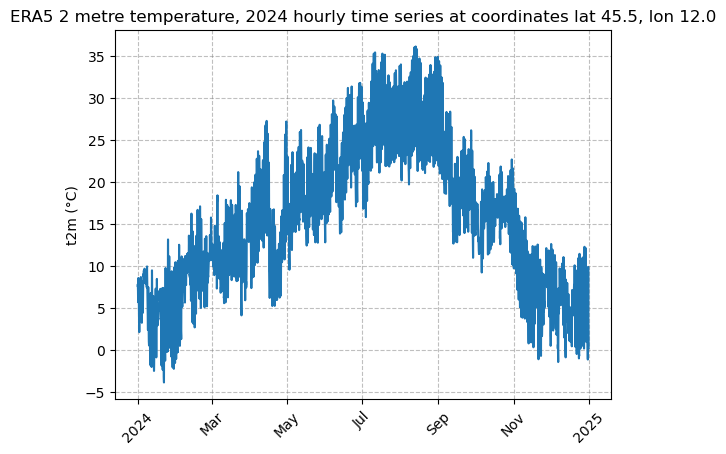

In [52]:
plot_datarray_ts(
    [da_point],
    [da_point["time"]],
    ["-"],
    ["t2m"],
    "ERA5 2 metre temperature, 2024 hourly time series at "
    f"coordinates lat {lat_nearest}, lon {lon_nearest}",
    "t2m (°C)",
    f"hourly_t2m_time_series_lat_{latitude}_lon_{longitude}.png",
    save_path,
)

A quick time series at the original resolution can be useful to spot any outliers or unexpected behaviour for temperature to show at this specific location.

### Empirical CDF of hourly temperature in year 2024

We now compute the empirical cumulative distribution function (ECDF) and the relative 0.25, 0.50, and 0.75 quantiles of the hourly temperature data at the chosen grid point. These calculations are routine in climate and energy analyses: knowing how a particular variable is distributed is essential for many applications, such as bias adjustment procedures.


The first step to achieve this is to sort our temperature data.

In [53]:
# create a 1D numpy array with temperature values
t2m_vals = da_point.values.flatten()
# sort the data
x = np.sort(t2m_vals)

Now we compute the ECDF: from our sorted array we assign each value its rank and divide by the total sample size.

In [54]:
# Compute ECDF values
y = np.arange(1, len(x) + 1) / len(x)

Next, we plot the calculated function. 

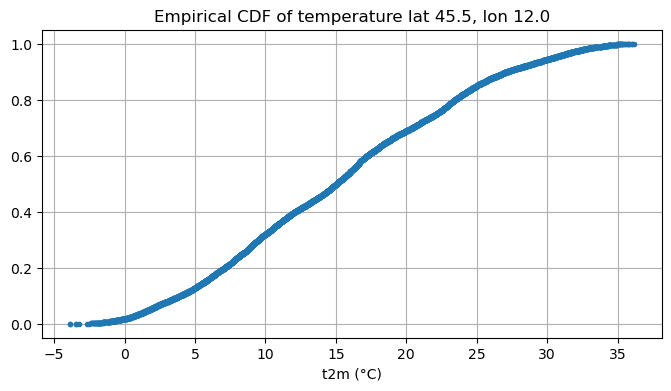

In [55]:
# Plot ECDF
plt.figure(figsize=(8, 4))
figname = "t2m_ecdf.png"
plt.plot(x, y, marker=".", linestyle="none")
plt.xlabel("t2m (°C)")
plt.title(f"Empirical CDF of temperature lat {lat_nearest}, lon {lon_nearest}")
plt.grid(True)
full_path = os.path.join(save_path, figname)
plt.savefig(full_path, bbox_inches="tight")
plt.show()
plt.close()

Finally, we print the chosen quantiles.

In [57]:
# Print quantiles
quantiles = [0.25, 0.50, 0.75]
q_val = np.quantile(t2m_vals, quantiles)

for i, q in zip(quantiles, q_val):
    print(f"{i} quantile: {q: .1f} °C")

0.25 quantile:  8.4 °C
0.5 quantile:  15.1 °C
0.75 quantile:  22.2 °C


### Compute daily and monthly averaged temperature time series at grid point nearest to the input location

Our last step is focused on the computation and visualization of daily and monthly mean temperatures for one particular grid point. We will plot the two time series in the same figure, in order to have a better understanding on how daily and monthly means behave with respect to each other.

We start by calculating the mean of the resampled temperature values.

In [58]:
# Part 3: daily and monthly mean temperature time evolution for the selected point
da_day_mean_t2m = da_point.resample(time="D").mean()  # daily resample
da_month_mean_t2m = da_point.resample(time="MS").mean()  # monthly resample

Next, we call the ```plot_datarray_ts``` function defined above. This time, the first argument will be a list of two elements, corresponding to the daily and monthly mean time series.

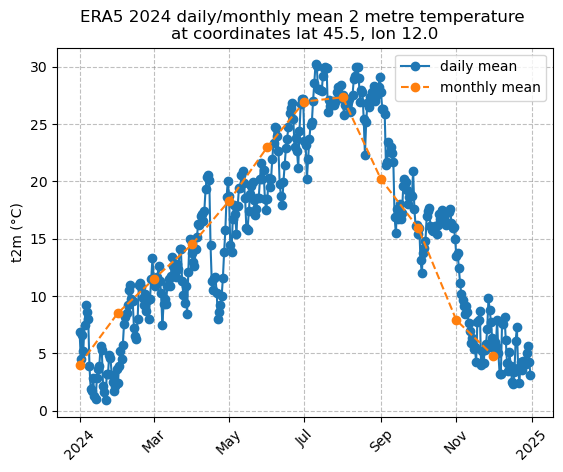

In [59]:
# call the plot function
plot_datarray_ts(
    [da_day_mean_t2m, da_month_mean_t2m],
    [da_day_mean_t2m["time"], da_month_mean_t2m["time"]],
    ["-", "--"],
    ["daily mean", "monthly mean"],
    "ERA5 2024 daily/monthly mean 2 metre temperature \n"
    f"at coordinates lat {lat_nearest}, lon {lon_nearest}",
    "t2m (°C)",
    f"daily_monthly_mean_t2m_time_series_lat_{latitude}_lon_{longitude}.png",
    save_path,
    markers=True,
    legend=True,
)

Starting from the original hourly temperature series, we can also derive the annual mean temperature at the selected grid point. Again, this can represent a precious information for downstream climate and energy analyses: repeating this across different NetCDF files allows us to assemble an annual mean time series at every grid point, providing a simple way to track changes in mean temperature and detect climate change signals.

In [60]:
print("Annual mean: ", float(da_point.mean()))

Annual mean:  15.26938533782959


## Take home messages 📌

In this notebook we explored how to work with climate data stored in a NetCDF file and learned to:

- Open the dataset and inspect its variables, dimensions, and metadata.
- Visualize the data producing a map, an empirical CDF plot and two line plots that show the temporal evolution at selected points.